In [1]:
%matplotlib inline
from __future__ import print_function

try:
    xrange
except NameError:
    xrange = range

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

<h2>KMeans法</h2>

KMeans法とは、教師なし機械学習手法の1つであり、非階層型クラスタリングの一種です。そのアルゴリズムはとてもシンプルです。

<br>
1)はじめにk個のシードを置く

2)各サンプルを最も近いシードと同じクラスターに分類

3)k個のクラスターそれぞれで重心を求め、それを新たなシードとして更新する

4)重心の位置が変化しなくなるまで 2) ~ 3) を繰り返す 

<br>
与えられたクラスター数$K$について、各クラスターに含まれる全てのデータ集合を$X_i (i=1, 2, \cdots , K)$と表現し、$X_i$に含まれる各データをxとします。また、そのクラスターの重心$\mu_i(i=1, 2, \cdots , K)$とします。
KMeans法の目的関数は、それぞれのクラスターに含まれるデータ$x$と重心$\mu_i$の距離の2乗の合計を、全てのクラスターに渡って足しあげたものいうことになります。そして、ゴールはこの目的関数を最小化するように、各データ$x$がどのクラスター$X_i$に属するかを調整することになります。そして、それを実現する方法が、上のアルゴリズムとなります。

\begin{equation*}
J(\mu) = \sum_{i=1}^{K} \sum_{x \in X_i} ||x - \mu_i||^2
\end{equation*}

<h2>ダミーデータを作ります</h2>

ダミーデータは可視化しやすいように、2次元とします。そしてダミーデータを作る上に2次元正規分布からサンプリングしますが、そのための関数を用意します。

In [2]:
def generate_2dim_normal(mean, variance, covariance, sample_size):
    cov = [[variance,covariance],
           [covariance,variance]]
    return np.random.multivariate_normal(mean, cov, sample_size)

4つのクラスターを作ります。

In [3]:
cluster1 = generate_2dim_normal(mean = [0, 8], variance=1, covariance=0, sample_size=500)
cluster2 = generate_2dim_normal(mean = [-1, 0], variance=1, covariance=0, sample_size=500)
cluster3 = generate_2dim_normal(mean = [10, 10], variance=1, covariance=0, sample_size=300)
cluster4 = generate_2dim_normal(mean = [5, 5.5], variance=0.8, covariance=-0.1, sample_size=200)
data = np.vstack((cluster1, cluster2, cluster3, cluster4))

それを可視化したのが以下です。

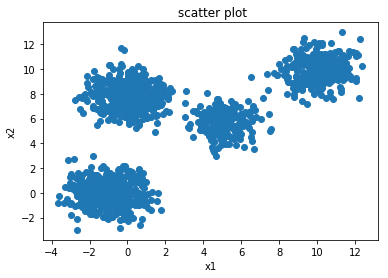

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data[:,0], data[:,1])
ax.set_title(u" scatter plot")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

　Scikit-LearnのKMeans法を使ってクラスターを作ってみましょう。

In [5]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300)

In [6]:
km.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [7]:
cluster_labels = km.predict(data)

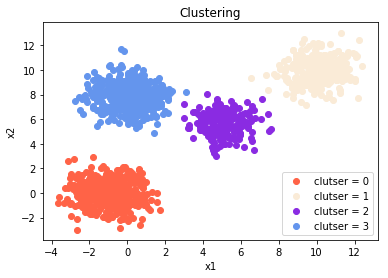

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colorlist = ['tomato', 'antiquewhite', 'blueviolet', 'cornflowerblue', 'darkgreen', 'seashell', 'skyblue', 'mediumseagreen', 'darksage', 'brown', 'rosybrown', 'crimson', 'lightpink','darkred', 'yellow', 'turquoise', 'papayawhip', 'lightsalmon', 'mediumvioletred', 'lemonchiffon', 'springgreen', 'deepskyblue', 'darkorange', 'sage', 'palegreen', 'peru', 'mediumslateblue', 'darkslategray', 'forestgreen', 'royalblue', 'lightgreen', 'paleturquoise', 'magenta',  'salmon', 'firebrick', 'gray', 'goldenrod']
cluster_ids = list(set(cluster_labels))

for k in range(len(cluster_ids)):
    cluster_id = cluster_ids[k]
    label_ = "clutser = %d"%cluster_id
    data_by_cluster = data[cluster_labels == cluster_id]
    ax.scatter(data_by_cluster[:,0], data_by_cluster[:,1], c=colorlist[k], label = label_)

ax.set_title(u"Clustering")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend(loc='lower right')

<h2>最適なクラスター数を探す: Elbow Method</h2>

In [9]:
max_cluster = 10
clusters_ = range(1, max_cluster)
intra_sum_of_square_list = []
for k in clusters_:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
    km.fit(data)
    intra_sum_of_square_list.append(km.inertia_)

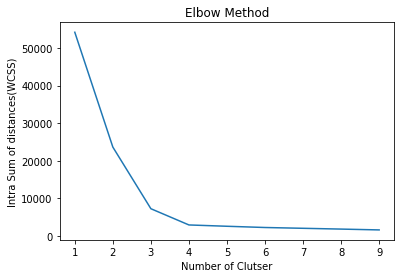

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title(u"Elbow Method")
ax.set_xlabel("Number of Clutser")
ax.set_ylabel("Intra Sum of distances(WCSS)")
plt.plot(clusters_, intra_sum_of_square_list)

<h2>最適なクラスター数を探す: シルエットプロット</h2>

In [11]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300)
km.fit(data)
cluster_labels = km.predict(data)

In [12]:
silhouette_avg = silhouette_score(data, cluster_labels)

In [13]:
each_silhouette_score = silhouette_samples(data, cluster_labels, metric='euclidean')

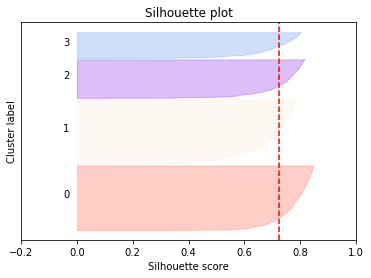

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = each_silhouette_score[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colorlist[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.3)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("Silhouette plot")
ax.set_xlabel("Silhouette score")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.2 ,0, 0.2, 0.4, 0.6, 0.8, 1])


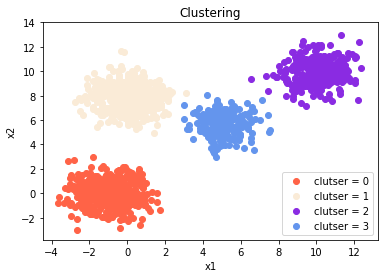

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cluster_ids = list(set(cluster_labels))

for k in range(len(cluster_ids)):
    cluster_id = cluster_ids[k]
    label_ = "clutser = %d"%cluster_id
    data_by_cluster = data[cluster_labels == cluster_id]
    ax.scatter(data_by_cluster[:,0], data_by_cluster[:,1], c=colorlist[k], label = label_)

ax.set_title(u"Clustering")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend(loc='lower right')

<h4>ここで問題: KMeans法で作られるクラスターはどのような仮定が置かれているのでしょうか？</h4>
ヒント: 重心と各データ点の2乗ということはどのような意味があるでしょうか？また、扱えるデータは質的データも大丈夫でしょうか？

<h2>実際のデータを使ってやってみましょう</h2>

本日使用するデータはこちらから入手しました。
http://archive.ics.uci.edu/ml/datasets/Wholesale+customers#

datasetフォルダのWholesale_customers_data.csvを読み込みましょう。

In [16]:
wholsesale_data = pd.read_csv("dataset/Wholesale_customers_data.csv")

上記のウェブページから抜粋したのが以下です。ポルトガルの卸売業者のカテゴリ別のSpending仕入量？のデータです。このデータを使って、卸売業者をセグメンテーションしてみましょう。

Abstract: The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

*	FRESH: annual spending (m.u.) on fresh products (Continuous); 
*	MILK: annual spending (m.u.) on milk products (Continuous); 
*	GROCERY: annual spending (m.u.)on grocery products (Continuous); 
*	FROZEN: annual spending (m.u.)on frozen products (Continuous) 
*	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous) 
*	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous); 
*	CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal) 
*	REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal) 

In [17]:
wholsesale_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


まず、気になるのはChannelとReginがカテゴリ変数だということです。KMeans法は連続値を想定しているということです。そのため、ChannelとReginは外しましょう。

In [18]:
cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]

In [19]:
dataset_for_cl = wholsesale_data[cols]
dataset_for_cl.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


忘れてはいけないのが前処理。ユークリッド距離に基づいてクラスタリングするので、スケールは重要。

In [20]:
#scaler = StandardScaler()
scaler = MaxAbsScaler()
dataset_for_cl_scaled = scaler.fit_transform(dataset_for_cl)

Elbow Methodを使って最適なクラスター数を探してみましょう。

In [21]:
max_cluster = 10
clusters_ = range(1, max_cluster)
intra_sum_of_square_list = []
for k in clusters_:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
    km.fit(dataset_for_cl)
    intra_sum_of_square_list.append(km.inertia_)

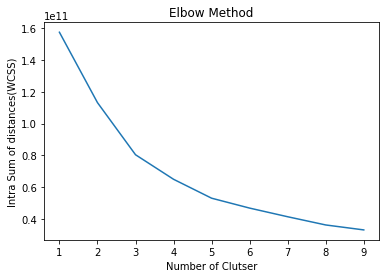

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title(u"Elbow Method")
ax.set_xlabel("Number of Clutser")
ax.set_ylabel("Intra Sum of distances(WCSS)")
plt.plot(clusters_, intra_sum_of_square_list)

シルエットプロットも見てみましょう。

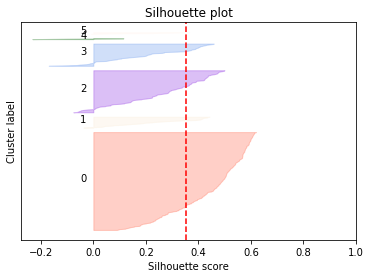

In [23]:
n_clusters = 6
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300)
km.fit(dataset_for_cl_scaled)
cluster_labels = km.predict(dataset_for_cl_scaled)

silhouette_avg = silhouette_score(dataset_for_cl_scaled, cluster_labels)

each_silhouette_score = silhouette_samples(dataset_for_cl_scaled, cluster_labels, metric='euclidean')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

y_lower = 10

for i in range(n_clusters):
        ith_cluster_silhouette_values = each_silhouette_score[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colorlist[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.3)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("Silhouette plot")
ax.set_xlabel("Silhouette score")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.2 ,0, 0.2, 0.4, 0.6, 0.8, 1])

最後に解釈してみましょう！

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.081563,0.034285,0.034057,0.046199,0.017011,0.020055
1,0.056777,0.234002,0.285775,0.030244,0.320392,0.054737
2,0.053828,0.115156,0.135542,0.025315,0.123568,0.034279
3,0.308166,0.063198,0.059393,0.096120,0.020464,0.043061
4,0.540090,0.409812,0.186621,0.625102,0.052735,0.431777
5,0.228290,0.591317,0.662559,0.043306,0.734176,0.056500


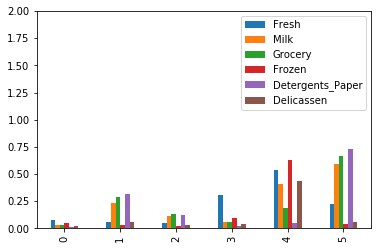

In [24]:
km_centers = pd.DataFrame(km.cluster_centers_, columns=cols)
km_centers.plot.bar(ylim=[0,2], fontsize=10)
km_centers